In [121]:
import numpy as np
import pandas as pd

import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL
import cv2 as cv

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

## Load the Dataset

In [4]:
# setup the input data folder
DATA_PATH = './data/'

In [5]:
# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [7]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet(DATA_PATH + 'train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet(DATA_PATH + 'test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test

In [12]:
train, test = load_images()

## Image Preprocessing and Augmentations

In [117]:
import torchvision

def threshold_image(img):
    '''
    Helper function for thresholding the images
    '''
    gray = PIL.Image.fromarray(np.uint8(img), 'L')
    ret,th = cv.threshold(np.array(gray),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def train_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.RandomSizedCrop(min_max_height=(int(HEIGHT // 1.1), HEIGHT), height = HEIGHT, width = WIDTH, p=p),
        albu.Rotate(limit=5, p=p)
    ], p=1.0)

## Define the Dataset

In [123]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236

def get_image(idx, df, labels):
    '''
    Helper function to get the image and label from the training set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    # get the label
    row = labels[labels.image_id == image_id]
    label = torch.tensor([row['grapheme_root'].values[0], 
                          row['vowel_diacritic'].values[0], 
                          row['consonant_diacritic'].values[0]])
    return img, label

def get_validation(idx, df):
    '''
    Helper function to get the validation image and image_id from the test set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    return img, image_id

class BengaliDataset(Dataset):
    '''
    Create custom Bengali dataset
    '''
    def __init__(self, df_images, transforms, df_labels = None, validation = False):
        self.df_images = df_images
        self.df_labels = df_labels
        self.transforms = transforms
        self.validation = validation

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        if not self.validation:
            img, label = get_image(idx, self.df_images, self.df_labels)
            img = threshold_image(img)
            aug = self.transforms(image = img)
            return TF.to_tensor(aug['image']), label
        else:
            img, image_id = get_validation(idx, self.df_images)
            img = threshold_image(img)
            return TF.to_tensor(img), image_id

In [124]:
# initialize train dataset
train_dataset = BengaliDataset(train, train_transforms(), train_labels)
sample_trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

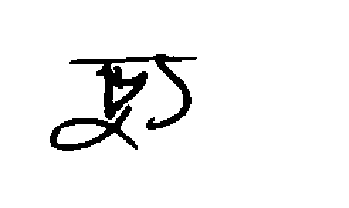

In [125]:
# plot sample train data
for img, label in sample_trainloader:
    plt.axis('off')
    plt.imshow(TF.to_pil_image(img.reshape(HEIGHT, WIDTH)), cmap='gray')

    break;